### Load Library

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
%matplotlib inline  

In [2]:
aislesDF = pd.read_csv('../aisles.csv')
departmentsDF = pd.read_csv('../departments.csv')
order_products_priorDF = pd.read_csv('../order_products__prior.csv')
order_products_trainDF = pd.read_csv('../order_products__train.csv')
ordersDF = pd.read_csv('../orders.csv')
productsDF = pd.read_csv('../products.csv')


### Load Data as Dataframe

In [3]:
# # Set data directory

# print('loading aisles')
# aislesDF =  pd.read_csv('../aisles.csv')

# print('loading departments')
# departmentsDF = pd.read_csv('../departments.csv')

# print('loading order_products_prior')
# order_products_priorDF = pd.read_csv('../order_products__prior.csv', dtype = {
#     'order_id':np.int32,
#     'product_id':np.uint16,
#     'add_to_cart_order': np.int16,
#     'reordered': np.int8
# })

# print('loading order_products_train')
# order_products_trainDF = pd.read_csv('../order_products__train.csv', dtype = {
#     'order_id':np.int32,
#     'product_id':np.uint16,
#     'add_to_cart_order': np.int16,
#     'reordered': np.int8
# })

# print('loading orders')

# ordersDF = pd.read_csv('../orders.csv', dtype = {
#     'order_id': np.int32,
#     'user_id': np.int32,
#     'eval_set': 'category',
#     'order_number': np.int16,
#     'order_dow': np.int8,
#     'order_hour_of_day': np.int8,
#     'days_since_prior_order': np.float32
# })

# print('loading products')
# productsDF = pd.read_csv('../products.csv', dtype = {
#         'product_id': np.uint16,
#         'order_id': np.int32,
#         'aisle_id': np.uint8,
#         'department_id': np.uint8
# })

loading aisles
loading departments
loading order_products_prior
loading order_products_train
loading orders
loading products


In [3]:
# Check datasets structure
print('aislesDF {}: {}'.format(aislesDF.shape, ', '.join(aislesDF.columns)))
print('departmentsDF {}: {}'.format(departmentsDF.shape, ', '.join(departmentsDF.columns)))
print('order_products_priorDF {}: {}'.format(order_products_priorDF.shape, ', '.join(order_products_priorDF.columns)))
print('order_products_trainDF {}: {}'.format(order_products_trainDF.shape, ', '.join(order_products_trainDF.columns)))
print('ordersDF {}: {}'.format(ordersDF.shape, ', '.join(ordersDF.columns)))
print('productsDF {}: {}'.format(productsDF.shape, ', '.join(productsDF.columns)))

aislesDF (134, 2): aisle_id, aisle
departmentsDF (21, 2): department_id, department
order_products_priorDF (32434489, 4): order_id, product_id, add_to_cart_order, reordered
order_products_trainDF (1384617, 4): order_id, product_id, add_to_cart_order, reordered
ordersDF (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
productsDF (49688, 4): product_id, product_name, aisle_id, department_id


### Get Features for Products

In [4]:
# products: productsDF joins products
# get reorder_rate = reordersTotal / ordersTotal
products_raw = pd.DataFrame()

products_raw['ordersTotal'] = order_products_priorDF.groupby(
    order_products_priorDF.product_id).size().astype(np.int32)

products_raw['reordersTotal'] = order_products_priorDF['reordered'].groupby(
    order_products_priorDF.product_id).sum().astype(np.float32)

products_raw['reorder_rate'] = (products_raw.reordersTotal / products_raw.ordersTotal).astype(np.float32)

products = productsDF.join(products_raw, on = 'product_id')
# products_new.set_index('product_id', drop = False, inplace = True)

del products_raw

products.head()

,product_id,product_name,aisle_id,department_id,ordersTotal,reordersTotal,reorder_rate
0,1,Chocolate Sandwich Cookies,61,19,1852.0,1136.0,0.613391
1,2,All-Seasons Salt,104,13,90.0,12.0,0.133333
2,3,Robust Golden Unsweetened Oolong Tea,94,7,277.0,203.0,0.732852
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329.0,147.0,0.446809
4,5,Green Chile Anytime Sauce,5,13,15.0,9.0,0.600000


### Get Features for Users

In [5]:
# ordersDF.reset_index(drop=True, inplace=True)
# Merge order_products_priorDF and ordersDF based on 'order_id'
priors = pd.merge(order_products_priorDF, ordersDF, how='left', on='order_id')

In [6]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [7]:
users = pd.DataFrame()
users['total_user'] = priors.groupby('product_id').size().astype(np.int16)
users['all_users'] = priors.groupby('product_id')['user_id'].apply(set)
users['total_distinct_users_perProduct'] = users.all_users.map(len)

In [8]:
users.head()

,total_user,all_users,total_distinct_users_perProduct
product_id,,,
1,1852,"{65537, 186370, 86020, 83973, 94215, 71688, 14...",716
2,90,"{45059, 10252, 113679, 153105, 22035, 5652, 35...",78
3,277,"{128640, 180481, 96386, 202359, 197255, 14984,...",74
4,329,"{175106, 140804, 123909, 195589, 30213, 137222...",182
5,15,"{184864, 179876, 58825, 151922, 102105, 160220}",6


In [9]:
# customers: total_items, all_products, total_unique_items,
# avgDaysBetwOrders, NumberOfOrders, avg_per_cart
customers_raw = pd.DataFrame()
customers_raw['avgDaysBetwOrders'] = ordersDF.groupby(
    'user_id')['days_since_prior_order'].mean().astype(np.float32)

customers_raw['NumberOfOrders'] = ordersDF.groupby('user_id').size().astype(np.int16)

In [10]:
customers = pd.DataFrame()

customers['total_items'] = priors.groupby('user_id').size().astype(np.int16)
customers['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
customers['total_unique_items'] = customers.all_products.map(len).astype(np.float32)

customers = customers.join(customers_raw)
customers['avg_per_cart'] = (customers.total_items / customers.NumberOfOrders).astype(np.float32)

In [11]:
del customers_raw
customers.head()

,total_items,all_products,total_unique_items,avgDaysBetwOrders,NumberOfOrders,avg_per_cart
user_id,,,,,,
1,59,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",18.0,19.000000,11,5.363636
2,195,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",102.0,16.285715,15,13.000000
3,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33.0,12.000000,13,6.769231
4,18,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",17.0,17.000000,6,3.000000
5,37,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",23.0,11.500000,5,7.400000


### Get Features for Users & Products

In [12]:
import numpy as np

customerXproduct = priors.copy()
customerXproduct['user_product'] = (customerXproduct.product_id + 
                                    customerXproduct.user_id * 100000).astype(np.int64)

customerXproduct = customerXproduct.sort_values('order_number')

customerXproduct = customerXproduct.groupby('user_product', sort=False).agg(
    {'order_id': ['size', 'last', 'first'], 'add_to_cart_order': 'sum'})

customerXproduct.columns = ['numbOfOrders', 'last_order_id', 'first_order_id', 'sum_add_to_cart_order']

customerXproduct = customerXproduct.astype(
    {'numbOfOrders': np.int16, 'last_order_id': np.int32, 'first_order_id': np.int32, 'sum_add_to_cart_order': np.int16}
)


In [15]:
customerXproduct = priors.copy()
customerXproduct['user_product'] = (customerXproduct.product_id + 
                                    customerXproduct.user_id * 100000).astype(np.int64)

customerXproduct = customerXproduct.sort_values('order_number')

customerXproduct = customerXproduct.groupby('user_product', sort=False).agg(
    {'order_id': ['size', 'last'], 'add_to_cart_order': 'sum'})

customerXproduct.columns = ['numbOfOrders', 'last_order_id', 'sum_add_to_cart_order']

# Assign the modified DataFrame back to the original variable
customerXproduct = customerXproduct.astype(
    {'numbOfOrders': np.int16, 'last_order_id': np.int32, 'sum_add_to_cart_order': np.int16}
)


In [13]:
customerXproduct

,numbOfOrders,last_order_id,first_order_id,sum_add_to_cart_order
user_product,,,,
8623906075,1,1520399,1520399,14
15429341329,1,2049062,2049062,3
15429323081,3,1489630,2049062,8
15429321527,3,2251505,2049062,14
15429335050,4,2251505,2049062,18
...,...,...,...,...
16999119311,1,51086,51086,6
8998913176,1,2768756,2768756,3
8162545368,1,310464,310464,13


In [14]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [15]:
def get_features(specified_orders, given_labels = False):
    print('create initial empty list')
    orders_list = []
    products_list = []
    labels = []
    
    training_index = set(order_products_trainDF.index)
    
    for row in specified_orders.itertuples():
        user_id = row.user_id
        order_id = row.order_id
        
        user_products = customers['all_products'][user_id]
        products_list += user_products
        orders_list += [order_id] * len(user_products)
        
        if given_labels:
            labels += [(order_id, product) in training_index for product in user_products]
        
    DF = pd.DataFrame({'order_id': orders_list, 'product_id': products_list}, dtype = np.int32)
    labels = np.array(labels, dtype = np.int8)
        
    print('get features for user part')
    DF['user_id'] = DF.order_id.map(ordersDF.user_id)
    DF['user_total_orders'] = DF.user_id.map(customers.NumberOfOrders)
    DF['user_total_items'] = DF.user_id.map(customers.total_items)
    DF['total_unique_items'] = DF.user_id.map(customers.total_unique_items)
    DF['user_avgDaysBetwOrders'] = DF.user_id.map(customers.avgDaysBetwOrders)
    DF['user_avg_per_cart'] = DF.user_id.map(customers.avg_per_cart) 
        
    print('get features for order part')
#     DF['dow'] = DF.order_id.map(ordersDF.order_dow)
    DF['order_hour_of_day'] = DF.order_id.map(ordersDF.order_hour_of_day)
    DF['days_since_prior_order'] = DF.order_id.map(ordersDF.days_since_prior_order)
    DF['daysSincePrior_avgDaysBetw_ratio'] = DF.days_since_prior_order / DF.user_avgDaysBetwOrders
        
    print('get features for product part')
    DF['aisle_id'] = DF.product_id.map(products.aisle_id)
    DF['department_id'] = DF.product_id.map(products.department_id)
    DF['product_order'] = DF.product_id.map(products.ordersTotal)
    DF['product_reorder'] = DF.product_id.map(products.reordersTotal)
    DF['product_reorder_rate'] = DF.product_id.map(products.reorder_rate)
    DF['product_distinct_user'] = DF.product_id.map(users.total_distinct_users_perProduct)
    
    print('get features for customerXproduct')
    DF['user_product_id']  = (DF.product_id + DF.user_id * 100000).astype(np.int64)
    DF.drop(['user_id'], axis = 1, inplace = True)
    DF['CP_numOrders'] = DF.user_product_id.map(customerXproduct.numbOfOrders)
    DF['CP_orders_ratio'] = DF.CP_numOrders / DF.user_total_orders
    DF['CP_last_order_id'] = DF.user_product_id.map(customerXproduct.last_order_id)
    DF['CP_avg_pos_inCart'] = DF.user_product_id.map(customerXproduct.sum_add_to_cart_order) / DF.CP_numOrders
    DF['CP_order_since_last'] = DF.user_total_orders - DF.CP_last_order_id.map(ordersDF.order_number)
    # DF['CP_hour_vs_last'] = abs(DF.order_hour_of_day - DF.CP_last_order_id.map(
    # ordersDF.order_hour_of_day)).map(lambda x: min(x, 24 - x)).astype(np.int8)
    # DF['CP_order_rate_since_first'] = DF.CP_numOrders / (DF.user_total_orders - DF.user_product_id.map(customerXproduct.first_order_id))
    
    DF.drop(['CP_last_order_id', 'user_product_id'], axis = 1, inplace = True)
    # print(orders_list)
    # print(products_list)
    # print(labels)
    return(DF, labels)
        

### Split Training and Test sets

In [16]:
test = ordersDF[ordersDF.eval_set == 'test']
train = ordersDF[ordersDF.eval_set == 'train']

order_products_trainDF.set_index(['order_id', 'product_id'], inplace = True, drop = False)

In [17]:
training_index = set(order_products_trainDF.index)
starting_values = list(training_index)[:5]  # Change 5 to the number of elements you want to see

# Display the starting values
print("Starting Values:", starting_values)

Starting Values: [(1526032, 24838), (754290, 35333), (799641, 13176), (1764801, 26939), (2523725, 11440)]


In [18]:
# select features to use for training
features_to_use = ['user_total_orders', 'user_total_items', 'total_unique_items', 
                  'user_avgDaysBetwOrders', 'user_avg_per_cart', 'order_hour_of_day',
                  'days_since_prior_order', 'daysSincePrior_avgDaysBetw_ratio',
                  'aisle_id', 'department_id', 'product_order', 'product_reorder',
                  'product_reorder_rate', 'CP_numOrders', 'CP_orders_ratio', 
                  'CP_avg_pos_inCart', 'CP_order_since_last',
                  'product_distinct_user'] #'dow'

In [19]:
def eval_fun(labels, preds):
    labels = labels.split(' ')
    preds = preds.split(' ')
    rr = (np.intersect1d(labels, preds))
    precision = np.float(len(rr)) / len(preds)
    recall = np.float(len(rr)) / len(labels)
    try:
        f1 = 2 * precision * recall / (precision + recall)
    except ZeroDivisionError:
        return (precision, recall, 0.0)
    return (precision, recall, f1)

In [20]:
train_train = train.sample(frac = 0.8, random_state=200)
train_test = train.drop(train_train.index)

In [21]:
train_test.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
74,525192,7,train,21,2,11,6.0
78,880375,8,train,4,1,14,10.0
395,2614670,27,train,82,5,14,4.0
627,2436259,44,train,4,0,12,30.0
658,2906490,47,train,6,4,22,16.0


In [22]:
print(order_products_trainDF)

                     order_id  product_id  add_to_cart_order  reordered
order_id product_id                                                    
1        49302              1       49302                  1          1
         11109              1       11109                  2          1
         10246              1       10246                  3          0
         49683              1       49683                  4          0
         43633              1       43633                  5          1
...                       ...         ...                ...        ...
3421063  14233        3421063       14233                  3          1
         35548        3421063       35548                  4          1
3421070  35951        3421070       35951                  1          1
         16953        3421070       16953                  2          1
         4724         3421070        4724                  3          1

[1384617 rows x 4 columns]


In [23]:
df_train_train, labels_train_train = get_features(train_train, given_labels=True)

df_train_test, labels_train_test = get_features(train_test,given_labels=True)

create initial empty list
get features for user part
get features for order part
get features for product part
get features for customerXproduct
create initial empty list
get features for user part
get features for order part
get features for product part
get features for customerXproduct


In [31]:
df_train_train['latry']=labels_train_train

In [ ]:
print(labels_train_train)

[0 0 0 ... 0 0 0]


In [28]:
from collections import Counter
frequency_count = Counter(labels_train_train)
for entry, frequency in frequency_count.items():
    print(f"Entry {entry} occurs {frequency} times.")

Entry 0 occurs 6120645 times.
Entry 1 occurs 661584 times.


In [ ]:
print(df_train_test, labels_train_test)

In [24]:
threshold = np.linspace(0.14, 0.22, num=9)
# threshold = np.linspace(0.9, 0.17, num=9)
# threshold = np.linspace(0.9, 0.14, num=9)

In [25]:
f1_score = []
d_train = xgb.DMatrix(df_train_train[features_to_use], labels_train_train)

In [27]:
print(df_train_train[features_to_use])

         user_total_orders  user_total_items  total_unique_items  \
0                       19               303               101.0   
1                       19               303               101.0   
2                       19               303               101.0   
3                       19               303               101.0   
4                       19               303               101.0   
...                    ...               ...                 ...   
6782224                 19               232               102.0   
6782225                 19               232               102.0   
6782226                 19               232               102.0   
6782227                 19               232               102.0   
6782228                 19               232               102.0   

         user_avgDaysBetwOrders  user_avg_per_cart  order_hour_of_day  \
0                      9.611111          15.947369                  5   
1                      9.611111      

In [28]:
for n in threshold:
    print(n)
    xgb_params = {
        "objective"         : "reg:logistic"
        ,"eval_metric"      : "logloss"
        ,"eta"              : 0.1
        ,"max_depth"        : 6
        ,"min_child_weight" :10
        ,"gamma"            :0.70
        ,"subsample"        :0.76
        ,"colsample_bytree" :0.95
        ,"alpha"            :2e-05
        ,"lambda"           :10
    }
    watchlist= [(d_train, "train")]
    num_round = 60
    
    print('model training')
    bst = xgb.train(params=xgb_params, dtrain=d_train, num_boost_round=num_round, evals=watchlist,
               verbose_eval = 10)

    print('predict on the test set')
    preds = bst.predict(xgb.DMatrix(df_train_test[features_to_use]))

    df_train_test_copy = df_train_test
    df_train_test_copy['pred'] = preds

    d = dict()
    for row in df_train_test_copy.itertuples():
        if row.pred > n:
            try:
                d[row.order_id] += ' ' + str(row.product_id)
            except:
                d[row.order_id] = str(row.product_id)

    for order in train_test.order_id:
        if order not in d:
            d[order] = 'None'

    sub = pd.DataFrame.from_dict(d, orient='index')

    sub.reset_index(inplace=True)
    sub.columns = ['order_id', 'products']

    df_train_test_copy['true'] = labels_train_test

    e = dict()
    for row in df_train_test_copy.itertuples():
        if row.true == 1:
            try:
                e[row.order_id] += ' ' + str(row.product_id)
            except:
                e[row.order_id] = str(row.product_id)

    for order in train_test.order_id:
        if order not in e:
            d[order] = 'None'

    sub_true = pd.DataFrame.from_dict(e, orient='index')

    sub_true.reset_index(inplace=True)

    sub_true.columns = ['order_id', 'true']
    
    print('merge result')
    sub_merge = pd.merge(sub_true, sub, how = 'inner', on = 'order_id')

    res = list()
    for entry in sub_merge.itertuples():
        res.append(eval_fun(entry[2], entry[3]))

    res = pd.DataFrame(np.array(res), columns=['precision', 'recall', 'f1'])
    
    print('append f1 score')
    f1_score.append(np.mean(res['f1']))

0.9
model training
[0]	train-logloss:0.63102
[10]	train-logloss:0.37218
[20]	train-logloss:0.32254
[30]	train-logloss:0.31327
[40]	train-logloss:0.31134
[50]	train-logloss:0.31069
[59]	train-logloss:0.31039
predict on the test set
merge result


c:\Users\u419161\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
c:\Users\u419161\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


append f1 score
0.8087500000000001
model training
[0]	train-logloss:0.63102
[10]	train-logloss:0.37218
[20]	train-logloss:0.32254
[30]	train-logloss:0.31327
[40]	train-logloss:0.31134
[50]	train-logloss:0.31069
[59]	train-logloss:0.31039
predict on the test set
merge result
append f1 score
0.7175
model training
[0]	train-logloss:0.63102
[10]	train-logloss:0.37218
[20]	train-logloss:0.32254
[30]	train-logloss:0.31327
[40]	train-logloss:0.31134
[50]	train-logloss:0.31069
[59]	train-logloss:0.31039
predict on the test set
merge result
append f1 score
0.62625
model training
[0]	train-logloss:0.63102
[10]	train-logloss:0.37218
[20]	train-logloss:0.32254
[30]	train-logloss:0.31327
[40]	train-logloss:0.31134
[50]	train-logloss:0.31069
[59]	train-logloss:0.31039
predict on the test set
merge result
append f1 score
0.535
model training
[0]	train-logloss:0.63102
[10]	train-logloss:0.37218
[20]	train-logloss:0.32254
[30]	train-logloss:0.31327
[40]	train-logloss:0.31134
[50]	train-logloss:0.31069


c:\Users\u419161\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  if __name__ == "__main__":


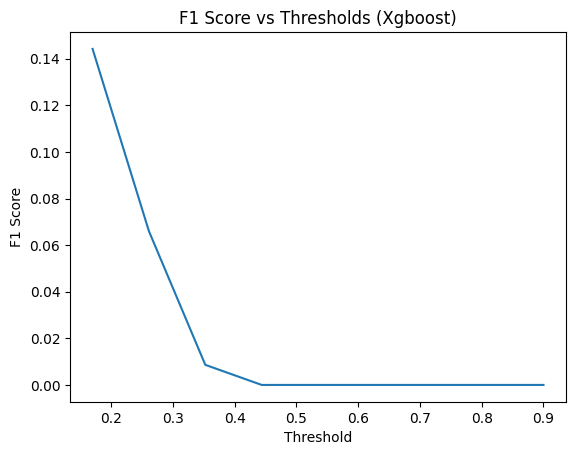

In [29]:
import matplotlib.pyplot as plt
# Plot F1 Score vs Thresholds
plt.plot(threshold,f1_score)
plt.ylabel('F1 Score')
plt.xlabel('Threshold')
# plt.axvline(x = 0.17,color='darkorange', linestyle='dashed', linewidth=1)
plt.title('F1 Score vs Thresholds (Xgboost)')
# plt.xticks(threshold, rotation = 'vertical')
plt.savefig('f1vsThresholds.png', dpi = 800, figsize = (1,1))